# Potato Disease Classification

Dataset credits: https://www.kaggle.com/arjuntejaswi/plant-village

# Import all the Dependencies

In [1]:
import tensorflow as tf
import os
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # to disable all debugging logs

# Copying only the necessary dataset (Only for Potato)

In [2]:
!mkdir "PlantVillage" # Creating PlantVillage Directory
!cp -r "../input/plant-village/PlantVillage/Potato___Early_blight/" "/kaggle/working/PlantVillage"
!cp -r "../input/plant-village/PlantVillage/Potato___Late_blight/" "/kaggle/working/PlantVillage"
!cp -r "../input/plant-village/PlantVillage/Potato___healthy/" "/kaggle/working/PlantVillage"

# Initializing Constants

In [3]:
#constants
IMAGE_SIZE=256
BATCH_SIZE = 32
CHANNELS =3
EPOCHS = 50
FILE_PATH="PlantVillage"

# Import data into tensorflow dataset object

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [5]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
# Display the no of batches (size = 32) created
len(dataset)

68

In [7]:
# Print one batch
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 0 1 0 1 0 0 0 0 1 1 1 1 1 0 0 1 0 2 0 1 1 0 1 0 2 1 0 0 0 2 1]


# Print one image from batch

[[[140. 137. 146.]
  [140. 137. 146.]
  [140. 137. 146.]
  ...
  [126. 120. 132.]
  [122. 116. 128.]
  [124. 118. 130.]]

 [[138. 135. 144.]
  [137. 134. 143.]
  [136. 133. 142.]
  ...
  [125. 119. 131.]
  [122. 116. 128.]
  [123. 117. 129.]]

 [[139. 136. 145.]
  [137. 134. 143.]
  [134. 131. 140.]
  ...
  [125. 119. 131.]
  [123. 117. 129.]
  [125. 119. 131.]]

 ...

 [[186. 189. 198.]
  [186. 189. 198.]
  [187. 190. 199.]
  ...
  [191. 189. 200.]
  [191. 189. 200.]
  [192. 190. 201.]]

 [[187. 190. 199.]
  [188. 191. 200.]
  [189. 192. 201.]
  ...
  [190. 188. 199.]
  [190. 188. 199.]
  [191. 189. 200.]]

 [[192. 195. 204.]
  [192. 195. 204.]
  [192. 195. 204.]
  ...
  [189. 187. 198.]
  [189. 187. 198.]
  [190. 188. 199.]]]


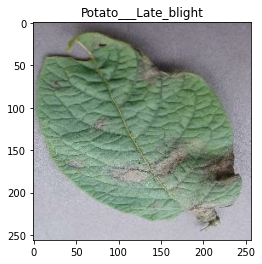

In [8]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].numpy())
    plt.title(class_names[label_batch[0]])
    plt.imshow(image_batch[0].numpy().astype("uint8")) # as images are in float

# Display more images from batch 

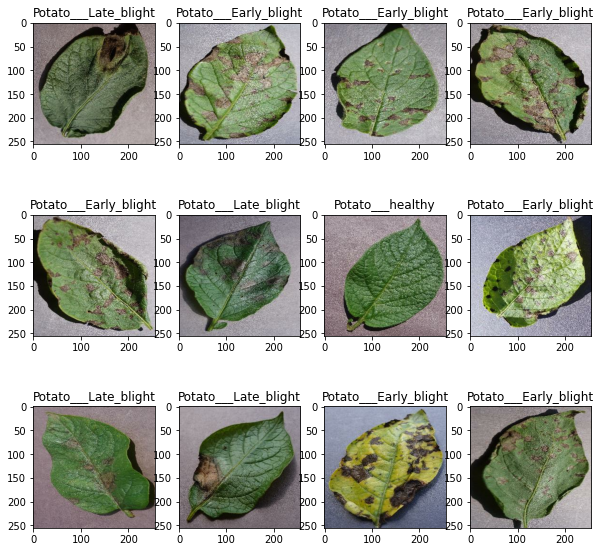

In [9]:
plt.figure(figsize = (10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        #print(image_batch[i].numpy())
        plt.title(class_names[label_batch[i]])
        plt.imshow(image_batch[i].numpy().astype("uint8")) # as images are in float

In [10]:
# Split the dataset into train, test, and validation
train_size = 0.8
len(dataset) * 0.8

54.400000000000006

In [11]:
# create train dataset
train_ds = dataset.take(54)
len(train_ds)

54

In [12]:
temp_ds = dataset.skip(54)

val_ds = temp_ds.take(7)
print(len(val_ds))

test_ds = temp_ds.skip(7)
print(len(test_ds))

7
7


# Split the dataset into train, test and validation (Using Function)

In [13]:
def get_dataset_partitions_tf(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [14]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [15]:
len(train_ds), len(val_ds), len(test_ds)

(54, 6, 8)

# Using caching and prefetching to improve the training performance

In [16]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Image Preprocessing : Rescaling and Resizing

In [17]:
resize_and_rescale = tf.keras.Sequential(
[
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

# Data Augmentation: Flipping and Rotation

In [18]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(factor = 0.5)
])

# Creating the Model

In [19]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,

    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size = (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size = (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size = (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape = input_shape)

In [20]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 60, 60, 64)         

In [21]:
model.compile(optimizer='adam', 
              loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False), 
              metrics = ['accuracy']
             )

# Training the Model

In [22]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size=BATCH_SIZE,
    verbose = 1,
    validation_data= val_ds
)

Epoch 1/50
54/54 [==============================] - 15s 89ms/step - loss: 0.9357 - accuracy: 0.5191 - val_loss: 0.8082 - val_accuracy: 0.5885
Epoch 2/50
54/54 [==============================] - 2s 36ms/step - loss: 0.6925 - accuracy: 0.7095 - val_loss: 0.5818 - val_accuracy: 0.7448
Epoch 3/50
54/54 [==============================] - 2s 37ms/step - loss: 0.3830 - accuracy: 0.8368 - val_loss: 0.3441 - val_accuracy: 0.8333
Epoch 4/50
54/54 [==============================] - 2s 36ms/step - loss: 0.2640 - accuracy: 0.8924 - val_loss: 0.2197 - val_accuracy: 0.9323
Epoch 5/50
54/54 [==============================] - 2s 36ms/step - loss: 0.2343 - accuracy: 0.9045 - val_loss: 0.2143 - val_accuracy: 0.9167
Epoch 6/50
54/54 [==============================] - 2s 36ms/step - loss: 0.2421 - accuracy: 0.9091 - val_loss: 0.2381 - val_accuracy: 0.8750
Epoch 7/50
54/54 [==============================] - 2s 37ms/step - loss: 0.2183 - accuracy: 0.9190 - val_loss: 0.1696 - val_accuracy: 0.9375
Epoch 8/50
5

In [23]:
score = model.evaluate(test_ds)

8/8 [==============================] - 3s 17ms/step - loss: 0.0633 - accuracy: 0.9727


In [24]:
score

[0.06327009201049805, 0.97265625]

In [25]:
history

In [26]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [27]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [28]:
history.history['accuracy']

[0.5190972089767456,
 0.7094907164573669,
 0.8368055820465088,
 0.8923611044883728,
 0.9045138955116272,
 0.9091435074806213,
 0.9189814925193787,
 0.9068287014961243,
 0.9166666865348816,
 0.9155092835426331,
 0.9317129850387573,
 0.9444444179534912,
 0.9554398059844971,
 0.9438657164573669,
 0.9496527910232544,
 0.9554398059844971,
 0.9577546119689941,
 0.9658564925193787,
 0.9641203880310059,
 0.9670138955116272,
 0.9733796119689941,
 0.9704861044883728,
 0.9612268805503845,
 0.9728009104728699,
 0.9803240895271301,
 0.9785879850387573,
 0.9612268805503845,
 0.9728009104728699,
 0.9716435074806213,
 0.9768518805503845,
 0.9878472089767456,
 0.9722222089767456,
 0.9866898059844971,
 0.9832175970077515,
 0.9803240895271301,
 0.9837962985038757,
 0.9762731194496155,
 0.9820601940155029,
 0.9918981194496155,
 0.9907407164573669,
 0.9901620149612427,
 0.984375,
 0.9878472089767456,
 0.9884259104728699,
 0.9861111044883728,
 0.9930555820465088,
 0.9924768805503845,
 0.9895833134651184,
 0

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# Visualizing Accuracy and Loss with No. of EPOCHS

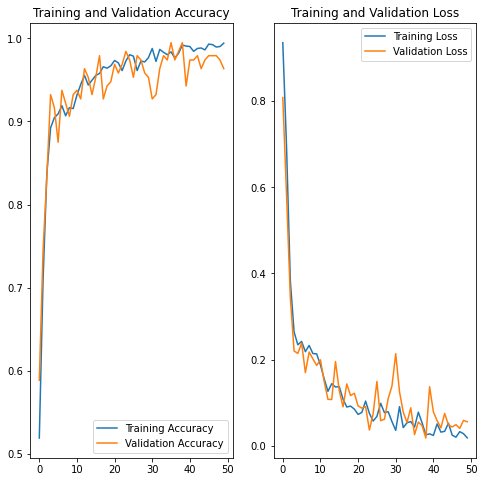

In [30]:
EPOCHS = 50

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Perfom Prediction

First image to predict
First image actual label: Potato___Late_blight
Predicted Label: Potato___Late_blight


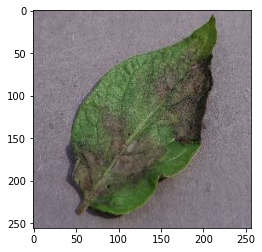

In [31]:
import numpy as np
for images_batch, labels_batch in dataset.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0]
    
    print("First image to predict")
    plt.imshow(first_image)
    print(f'First image actual label: {class_names[first_label]}')
    
    
    # Predict
    batch_prediction = model.predict(images_batch)
    print(f'Predicted Label: {class_names[np.argmax(batch_prediction[0])]}')

In [32]:
# Convert the above code into a function
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i])
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

# Predict Multiple Images

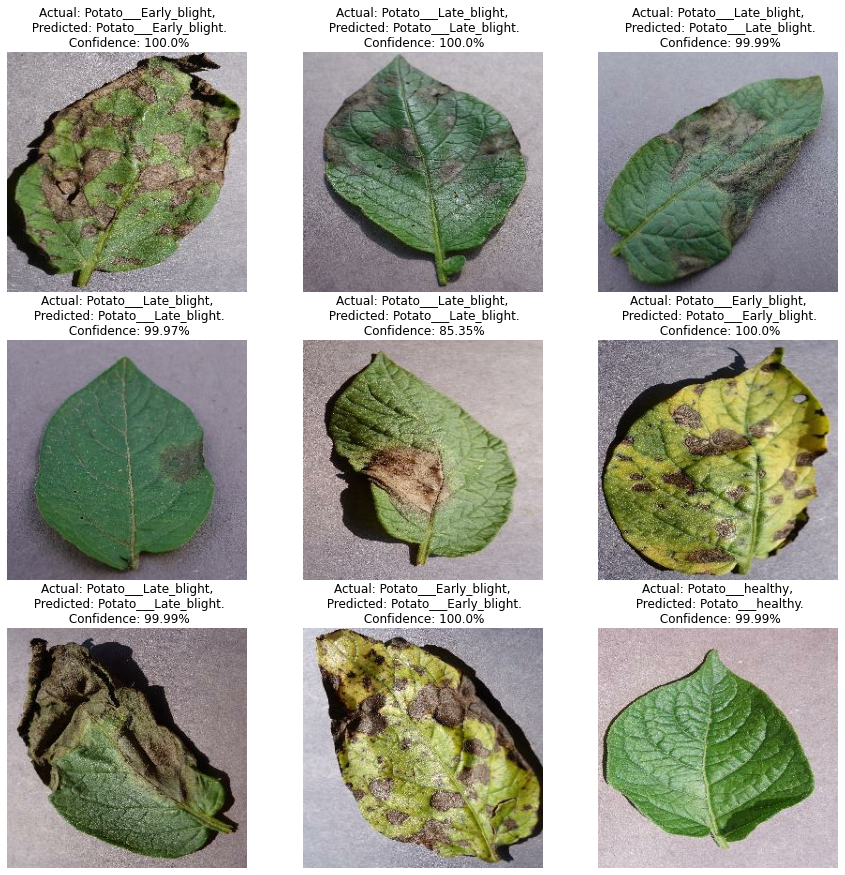

In [33]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class, confidence = predict(model, images[i])
        actual_class = class_names[int(labels[i])] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")
    break

# Save Ist Model

In [34]:
model.save("../models/basic_potatoes.h5")

# IInd Approach

# Split the Folders

In [35]:
!pip install split-folders

In [36]:
!split_folders --output dataset --ratio .7 .1 .2 -- PlantVillage

Copying files: 2152 files [00:00, 6628.37 files/s]


# Creating Data Generators

In [37]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        horizontal_flip=True
)

validation_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        horizontal_flip=True
)

test_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
        'dataset/train',
        target_size=(IMAGE_SIZE,IMAGE_SIZE),
        batch_size=32,
        class_mode="sparse",
)

validation_generator = validation_datagen.flow_from_directory(
        'dataset/val',
        target_size=(IMAGE_SIZE,IMAGE_SIZE),
        batch_size=32,
        class_mode="sparse"
)

test_generator = test_datagen.flow_from_directory(
        'dataset/test',
        target_size=(IMAGE_SIZE,IMAGE_SIZE),
        batch_size=32,
        class_mode="sparse"
)

Found 1506 images belonging to 3 classes.
Found 215 images belonging to 3 classes.
Found 431 images belonging to 3 classes.


In [38]:
train_generator.class_indices

{'Potato___Early_blight': 0, 'Potato___Late_blight': 1, 'Potato___healthy': 2}

In [39]:
class_names = list(train_generator.class_indices.keys())
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

# Building the Model

In [40]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    layers.InputLayer(input_shape=input_shape),
    layers.Conv2D(32, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

In [41]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 60, 60, 64)        36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 28, 28, 64)       

### Compiling the Model
We use `adam` Optimizer, `SparseCategoricalCrossentropy` for losses, `accuracy` as a metric

In [42]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Training the Model

In [43]:
history = model.fit(
    train_generator,
    steps_per_epoch=47, # 1506 / 32
    batch_size=32,
    validation_data=validation_generator,
    validation_steps=6, # 215 / 32
    verbose=1,
    epochs=20,
)

Epoch 1/20
47/47 [==============================] - 25s 523ms/step - loss: 0.9603 - accuracy: 0.4647 - val_loss: 0.8845 - val_accuracy: 0.4740
Epoch 2/20
47/47 [==============================] - 23s 499ms/step - loss: 0.8690 - accuracy: 0.5007 - val_loss: 0.8218 - val_accuracy: 0.5469
Epoch 3/20
47/47 [==============================] - 24s 515ms/step - loss: 0.6460 - accuracy: 0.6872 - val_loss: 0.5802 - val_accuracy: 0.7292
Epoch 4/20
47/47 [==============================] - 24s 508ms/step - loss: 0.5090 - accuracy: 0.7693 - val_loss: 0.5054 - val_accuracy: 0.7656
Epoch 5/20
47/47 [==============================] - 24s 501ms/step - loss: 0.3760 - accuracy: 0.8548 - val_loss: 0.3685 - val_accuracy: 0.8698
Epoch 6/20
47/47 [==============================] - 23s 498ms/step - loss: 0.2647 - accuracy: 0.8948 - val_loss: 0.3636 - val_accuracy: 0.8281
Epoch 7/20
47/47 [==============================] - 24s 506ms/step - loss: 0.2228 - accuracy: 0.9199 - val_loss: 0.1625 - val_accuracy: 0.9375

In [44]:
scores = model.evaluate(test_generator)

14/14 [==============================] - 6s 443ms/step - loss: 0.4450 - accuracy: 0.8910


In [45]:
scores

[0.44504785537719727, 0.8909512758255005]

Scores is just a list containing loss and accuracy value

# Visualizing Accuracy and Loss with No. of EPOCHS

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

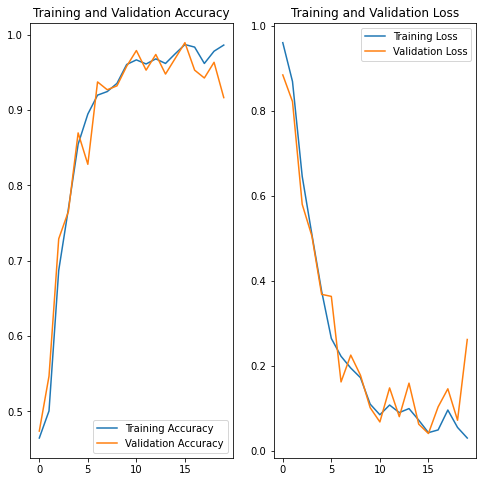

In [47]:
EPOCHS = 20

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Predict Multiple Images

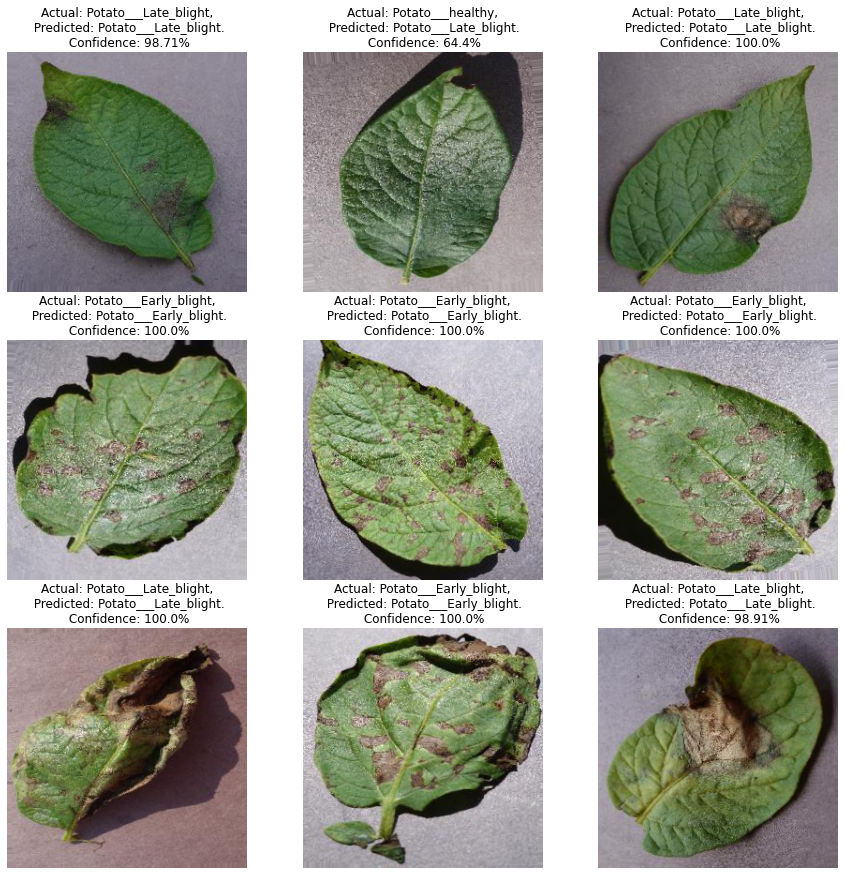

In [48]:
plt.figure(figsize=(15, 15))
for images, labels in test_generator:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        
        predicted_class, confidence = predict(model, images[i])
        actual_class = class_names[int(labels[i])] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")
    break

# Saving the Final Model

In [49]:
model.save("../potatoes.h5")